In [2]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [3]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

In [4]:
ibc_df.head()

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448


In [5]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [6]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms
# texp = 5

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)
# bands = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']

# bands = ['lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']
bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']



# zeropoints from https://smtn-002.lsst.io/
# zeropoints = [26.52, 28.51, 28.36, 28.17, 27.78, 26.82]
# zeropoints = [28.51, 28.36, 28.17, 27.78, 26.82]
zeropoints = [28.51, 28.36, 28.17, 27.78]


num_bands = len(bands)

obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':10.*np.ones(num_points*num_bands)})

In [7]:
def simulate_ibc(true_z, texp, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp, mej, fni, vej])

    
    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'texp': texp, 'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(obs, arnett_model, [params])
    
    
    mej = (mej * u.Msun).to(u.g)
    vej = vej * u.km/u.s
    opac = 0.1 *u.cm * u.cm/u.g        

    # Diffusion timescale in days
    td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
    # print(td)
    # lcs[0]['flux'][lcs[0]['flux'] <= 0] = 0.1
    return lcs

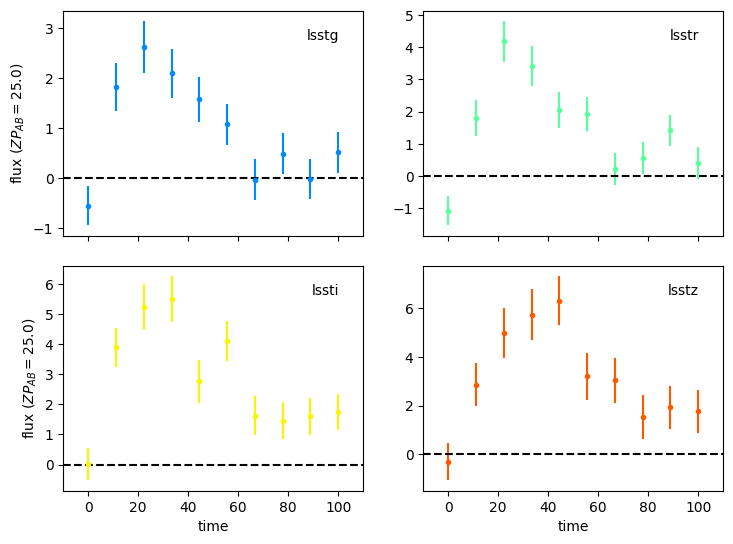

In [8]:
# light_curve = simulate_ibc(0.05, 0, 3, 0.1, 10000)
# light_curve = simulate_ibc(0.116, 5.76, 0.4841, 0.0309, 37270.73384139233)
# light_curve = simulate_ibc(0.116, 2.4, 0.4841, 0.0309, 37270.73384139233)

light_curve = simulate_ibc(0.18, 0, 5.4863 , 0.0456, 10416.298485236222)


sncosmo.plot_lc(light_curve[0]);

In [9]:
def get_texp_guess(light_curve):
    max_index = np.argmax(light_curve[0]['flux'][light_curve[0]['band'] == 'lssti'])
    print(max_index)
    max_time = (light_curve[0]['time'][light_curve[0]['band'] == 'lssti'])[max_index]
    print((light_curve[0]['time'][light_curve[0]['band'] == 'lssti']))
    print(max_time)
    return max_time - 5.

In [10]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 0.2), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 0.2), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [11]:
def td(mej, vej):
    mej = (mej * u.Msun).to(u.g)
    vej = vej * u.km/u.s
    # Diffusion timescale in days
    opac = 0.1 *u.cm * u.cm/u.g        
    td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day) 
    return td

In [12]:
td(1, 10000), td(0.2, 20000)

(<Quantity 11.38894709 d>, <Quantity 3.6015013 d>)

In [13]:
result, fitted_model = fit_ibc(0.18, light_curve)

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [14]:
result

      success: True
      message: 'Covariance may not be accurate. Covariance not positive definite. Covariance forced positive definite.'
        ncall: 277
        chisq: 39.11738724485296
         ndof: 36
  param_names: ['z', 't0', 'texp', 'mej', 'fni', 'vej']
   parameters: array([0.00000000e+00, 0.00000000e+00, 4.81701716e-05, 4.75148834e+00,
       4.86947399e-02, 9.75652454e+03])
 vparam_names: ['texp', 'mej', 'fni', 'vej']
   covariance: array([[ 5.95693316e-05, -5.10318782e-06, -2.18692930e-07,
        -1.28446600e-02],
       [-5.10318782e-06,  2.84758345e-02, -3.10463988e-04,
         1.76452970e-01],
       [-2.18692930e-07, -3.10463988e-04,  3.40324568e-06,
        -1.06642413e-03],
       [-1.28446600e-02,  1.76452970e-01, -1.06642413e-03,
         1.61732211e+02]])
       errors: OrderedDict([('texp', 0.30689078653075963), ('mej', 0.1687156628660591), ('fni', 0.0018446100726509929), ('vej', 12.717393656226704)])
         nfit: 1
    data_mask: array([ True,  True,  Tru

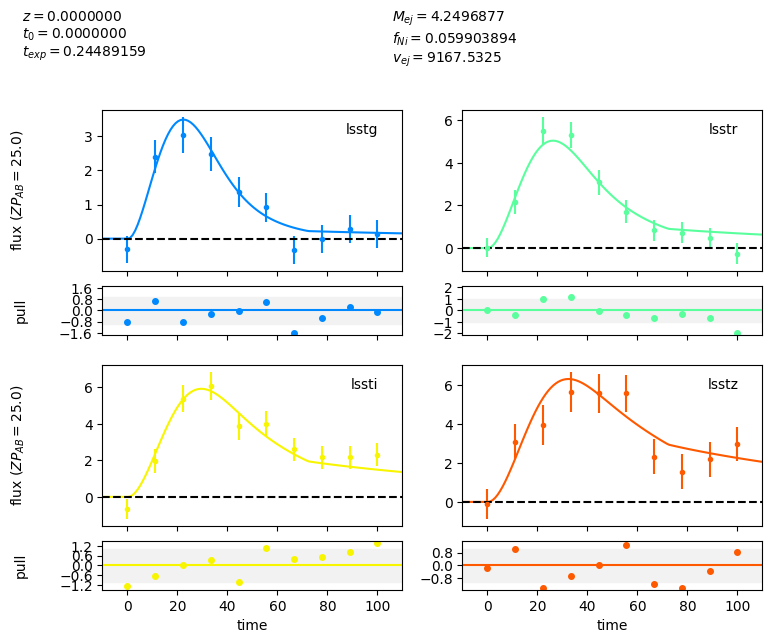

In [93]:
sncosmo.plot_lc(light_curve[0], model=fitted_model);

In [15]:
num_to_fit = 10

fits = {'true_z': [], 'true_texp': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_texp':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    this_texp = np.random.uniform(0., 7.)
    if true_z > 0.2 or vej.value > 20000:
        continue
    
    print(true_z, this_texp)

    print(mej, fni, vej)
    try:
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej.value)
        # sncosmo.plot_lc(lcs[0])

        result, fitted_model = fit_ibc(true_z, lcs)
        # sncosmo.plot_lc(lcs[0], model=fitted_model)
        # plt.show()
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_texp'].append(this_texp)
        fits['true_mej'].append(mej)
        fits['true_fni'].append(fni)
        fits['true_vej'].append(vej.value)
        fits['fit_texp'].append(result_dict['texp'])
        fits['fit_mej'].append(result_dict['mej'])
        fits['fit_fni'].append(result_dict['fni'])
        fits['fit_vej'].append(result_dict['vej'])
    except Exception as e:
        print(e)

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.168 6.4225780417920175
9.8016 0.0245 9565.13884330619 km / s
0.173 4.281106630307365
1.904 0.0166 16348.990983769314 km / s


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
0.187 5.918531929447584
1.0118 0.0617 15126.84991592506 km / s
0.195 4.53972433262542
7.6253 0.0184 4905.6166488100735 km / s
0.095 1.5018315412362873
2.5761 0.0146 15028.819140533313 km / s
0.17 2.8994210394060795
1.7163 0.0156 14248.0156368035 km / s


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
0.175 5.707680388827265
7.9896 0.0192 7171.612516212528 km / s
0.18 6.015175243778878
5.4863 0.0456 10416.298485236222 km / s
0.184 4.7270329262657915
9.8016 0.0245 9565.13884330619 km / s
0.174 3.652276667906699
7.124 0.0112 7986.630416412141 km / s
7.149439096450806


Text(0, 0.5, 'Fit texp')

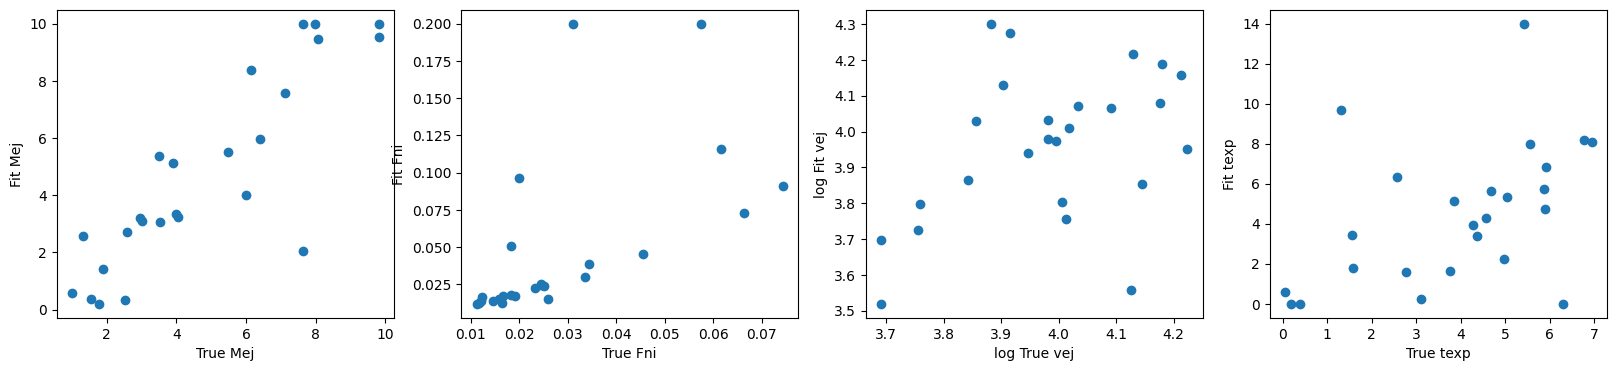

In [84]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")
ax[3].plot(fits['true_texp'], fits['fit_texp'], 'o')
ax[3].set_xlabel("True texp")
ax[3].set_ylabel("Fit texp")

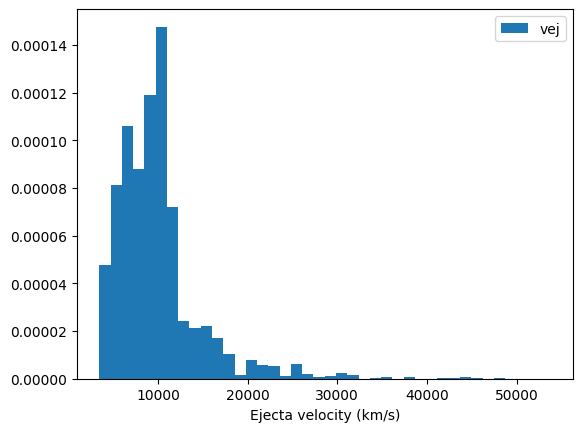

In [16]:
vej = np.sqrt(
    2 * ibc_df['Kinetic_energy'].values * 1e51 * u.erg / (ibc_df['Mejecta'].values * u.Msun)
)
vej = vej.to(u.km / u.s)
plt.hist(vej.value, bins=40, density=True, label="vej")
plt.xlabel("Ejecta velocity (km/s)")
plt.legend()


(array([2.07478633e-02, 9.22457832e-02, 2.10547751e-01, 3.52009032e-01,
        5.21609113e-01, 6.79261557e-01, 8.63220725e-01, 9.88068057e-01,
        1.16797161e+00, 1.27742637e+00, 1.45128564e+00, 1.52107675e+00,
        1.68399054e+00, 1.71884695e+00, 1.79833084e+00, 1.74175572e+00,
        1.72060073e+00, 1.56861676e+00, 1.46899570e+00, 1.25273250e+00,
        1.03697038e+00, 8.45980425e-01, 6.47646511e-01, 5.08346139e-01,
        3.42707726e-01, 2.23074763e-01, 1.20165361e-01, 6.61269636e-02,
        3.47781166e-02, 2.14681665e-02, 1.23547654e-02, 1.02408322e-02,
        6.81156267e-03, 4.44708919e-03, 3.44492825e-03, 2.52106113e-03,
        1.72246412e-03, 1.19006612e-03, 8.45573297e-04, 7.20303179e-04]),
 array([0.011   , 0.049475, 0.08795 , 0.126425, 0.1649  , 0.203375,
        0.24185 , 0.280325, 0.3188  , 0.357275, 0.39575 , 0.434225,
        0.4727  , 0.511175, 0.54965 , 0.588125, 0.6266  , 0.665075,
        0.70355 , 0.742025, 0.7805  , 0.818975, 0.85745 , 0.895925,
      

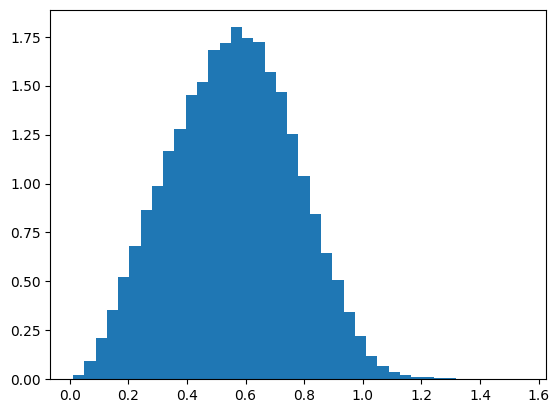

In [94]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True, label="x1")

In [18]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [19]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [20]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

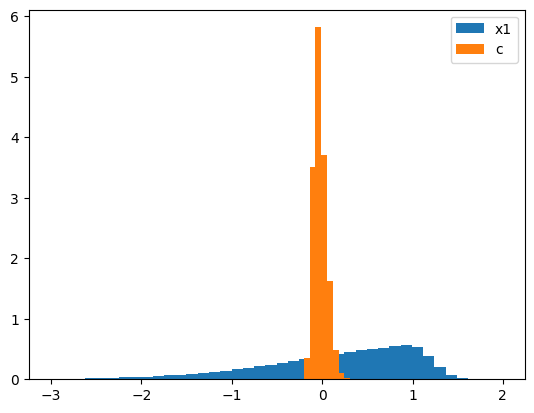

In [21]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [22]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(obs, this_ia_model, [params])

    return lcs

In [23]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [24]:
light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)

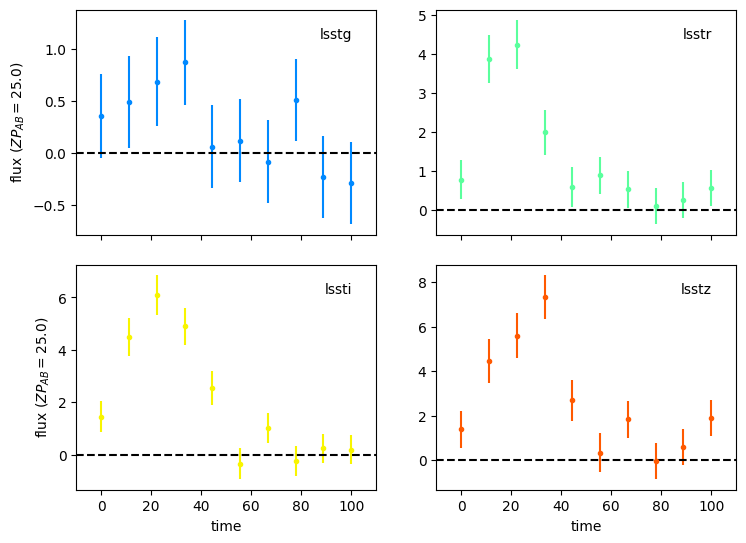

In [25]:
sncosmo.plot_lc(light_curve[0]);

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


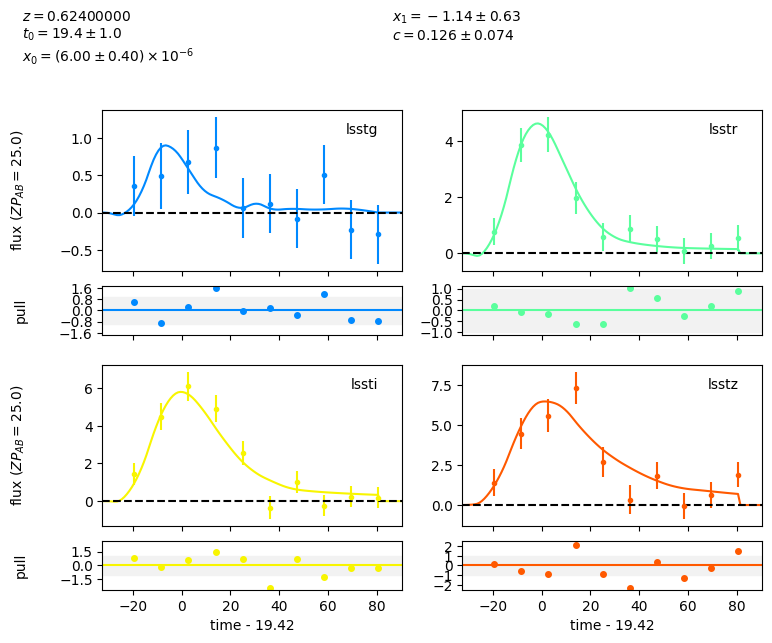

In [26]:
ia_result, ia_fitted_model = fit_ia(0.624,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

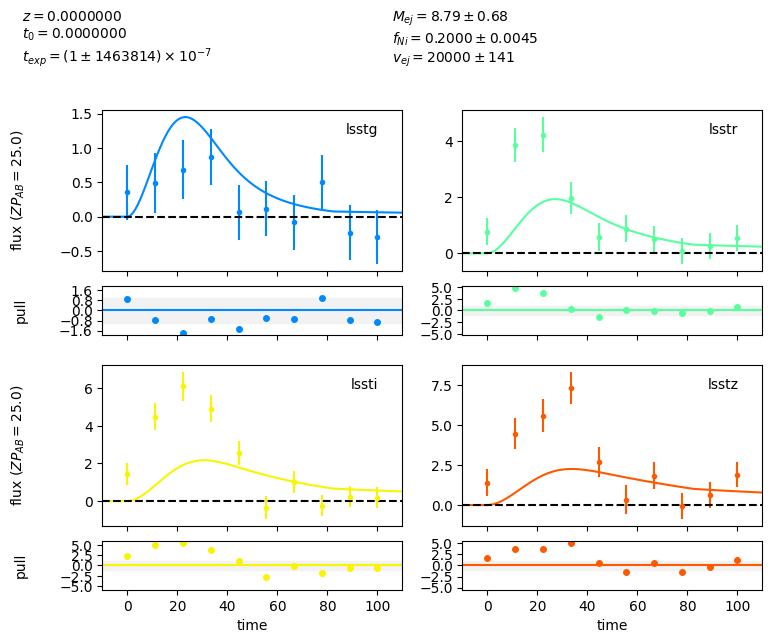

In [27]:
ibc_result, ibc_fitted_model = fit_ibc(0.624,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [28]:
num_to_fit = 100

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

# t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    if true_z > 0.2:
        continue
    # try:
    this_t0 = np.random.normal(14., 7.)
    print(true_z, this_t0)
    lcs = simulate_ia(true_z, this_t0, x0, x1, c)

    result, model = fit_ia(true_z, lcs)

    result_dict = sncosmo.flatten_result(result)
    fits['true_z'].append(true_z)
    fits['true_t0'].append(this_t0)
    fits['true_x0'].append(x0)
    fits['true_x1'].append(x1)
    fits['true_c'].append(c)
    fits['fit_t0'].append(result_dict['t0'])
    fits['fit_x0'].append(result_dict['x0'])
    fits['fit_x1'].append(result_dict['x1'])
    fits['fit_c'].append(result_dict['c'])
    # except:
    #     print(true_z)
    #     print("Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.072 16.72025454917549
0.177 23.780926154651397
0.182 12.872457948743
0.188 13.706869991760549
0.147 19.27783440395675
0.103 -2.9149765786299824
0.187 18.322075251410467
0.138 17.176989168037714
0.16 9.967630862588958
0.1 12.917209184418862
0.176 27.60326839028191
0.18 9.651117814779207
0.127 10.75686846120194
0.103 21.32581528481044
0.131 22.452999195833094
0.18 15.644607076292878
0.151 13.727041776152785
0.19 7.774876075096202
0.147 7.320096186053722
0.087 3.6155399566268187
0.092 20.42646351033518
0.186 4.959668237525079
0.115 13.149485891295855
0.134 9.740836124832208
0.154 11.20503949248274
0.055 24.846872452149476
0.13 22.437011343505823
0.135 7.733015250242033
0.177 6.49844486252943
0.163 21.274832923026864
0.14 9.671697110216245
0.194 2.81621226513821
0.116 19.45278808400116
0.184 4.800660632826496
0.081 13.907681910993709
0.15 15.329892634153882
0.175 2.7501788583036433
0.143 8.29529224860027
0.154 13.717928023099667
0.058 0.5360614671894286
0.101 6.647555476291953
0.123 4.49

Text(0, 0.5, 'Fit t0')

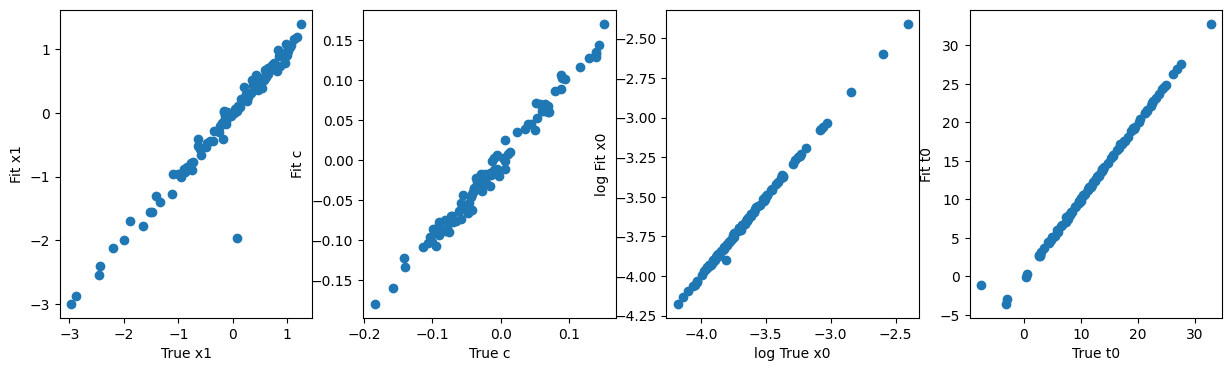

In [32]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")
ax[3].plot(fits['true_t0'], fits['fit_t0'], 'o')
ax[3].set_xlabel("True t0")
ax[3].set_ylabel("Fit t0")

In [33]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
            


In [34]:
SN('ia', {'z':0.6, 't0':20, 'x0':1e-5, 'x1':0.1, 'c':0.1}).true_class

'ia'

In [35]:
num_to_fit = 100

# t0 = 20

true_ia_sne = []

# fit true Ias as both
start = time.time()
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    if true_z > 0.2:
        continue
    
    try:
        this_t0 = np.random.normal(14., 7.)
        print(true_z, this_t0)
        
        true_dict = {'z': true_z, 't0':this_t0, 'x0':x0, 'x1':x1, 'c':c}
        this_sn = SN('ia', true_dict)

        lcs = simulate_ia(true_z, this_t0, x0, x1, c)

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)
        # print(sncosmo.flatten_result(ibc_result))
        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))

        true_ia_sne.append(this_sn)
    except Exception as e:
        print(e)

    if len(true_ia_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)


0.072 13.089226569029908


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


0.177 13.020269475885419
0.182 19.755997618803544
0.188 16.07255750169623


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
result is NaN for [ 0 0 0.00986009 9.88256 0.178035 20000 ]
0.147 25.780621660626025
0.103 15.702690098113218
Trying again...
0.187 15.802088411205593
0.138 19.121700284149693
0.16 8.003367743409727
0.1 23.63001657572807
0.176 13.090748332804754
0.18 13.810988706977332
0.127 9.959174178996415
0.103 9.98706023707155
0.131 9.66198833165734
0.18 7.190699912914922
0.151 24.098960136886905
0.19 7.2282800546851576
0.147 13.153633507808474
Trying again...
0.087 5.360246153362429
0.092 14.224448501945904
0.186 22.47025241891159
0.115 23.409858431898847
0.134 9.337720065233121
0.154 18.95895602505513
0.055 17.908409551242528
0.13 15.258316996998873
0.135 19.30527709377713
0.177 7.8448986574675565
0.163 9.246382939559304
0.14 14.519255807953297
0.194 15.359129933120894
0.116 13.44789158288733
0.184 19.08090104412443
0.081 17.121850042727115
0.15 5.0033604435187335
0.175 15.011940516705568
0.143 19.027526024596575
0.154 10.31446328493306
0.058 14.983196064828915
0.101 9.4768267250

In [41]:
true_ibc_sne = []

# Fit ibc as both
start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = (((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)).value
    
    if true_z > 0.2 or vej > 20000:
        continue

    print(mej, fni, vej)

    
    try:
        this_texp = np.random.uniform(0., 7.)

        true_dict = {'z': true_z, 'texp': this_texp, 'mej':mej, 'fni':fni, 'vej':vej}
        this_sn = SN('ibc', true_dict)
        
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej)

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)

        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        true_ibc_sne.append(this_sn)

    except Exception as e:
        print(e)

    if len(true_ibc_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

9.8016 0.0245 9565.13884330619
1.904 0.0166 16348.990983769314


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:377: RuntimeWarning: overflow encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)


Trying again...
`y` must contain only finite values.
1.0118 0.0617 15126.84991592506
7.6253 0.0184 4905.6166488100735
2.5761 0.0146 15028.819140533313
1.7163 0.0156 14248.0156368035
Trying again...
7.9896 0.0192 7171.612516212528
5.4863 0.0456 10416.298485236222
9.8016 0.0245 9565.13884330619
7.124 0.0112 7986.630416412141
1.5546 0.0576 10136.265091056046
6.1382 0.0252 10823.865766773122
Trying again...
3.9105 0.0121 7621.265636557195
2.5183 0.02 13342.266988560003
7.6253 0.0184 4905.6166488100735
3.0187 0.0159 8235.85996368419
2.9674 0.0232 13498.560864989795
5.9891 0.0124 10285.302389562787
4.0009 0.0345 5700.750956053673
1.7726 0.0311 13959.893591132919
1.3314 0.0259 16743.995356379153
3.5035 0.0165 9904.375931952241
6.3879 0.0117 12355.211252858355
8.0723 0.0335 8856.623071343472
3.5205 0.0664 6949.105690464828
4.046 0.0744 5748.580347068582
1.3314 0.0259 16743.995356379153
6.2457 0.0856 10013.272631574178
5.2759 0.0346 8667.9616750557
3.3284 0.0159 8803.302749295292
1.5202 0.07 15

In [52]:
np.savez("fitted_sne.npz", ia=true_ia_sne, ibc=true_ibc_sne)

In [42]:
all_sne = true_ia_sne + true_ibc_sne
fit_x1 = [sn.ia_fit['x1'] for sn in all_sne]
fit_t0 = [sn.ia_fit['t0'] for sn in all_sne]
fit_c = [sn.ia_fit['c'] for sn in all_sne]
fit_x0 = [sn.ia_fit['x0'] for sn in all_sne]
fit_mej = [sn.ibc_fit['mej'] for sn in all_sne]
fit_fni = [sn.ibc_fit['fni'] for sn in all_sne]
fit_vej = [sn.ibc_fit['vej'] for sn in all_sne]

(array([  3.,   0.,  17., 108.,  59.,   8.,   3.,   0.,   0.,   2.]),
 array([-37.76674547, -22.19821654,  -6.6296876 ,   8.93884134,
         24.50737027,  40.07589921,  55.64442815,  71.21295708,
         86.78148602, 102.35001495, 117.91854389]),
 <BarContainer object of 10 artists>)

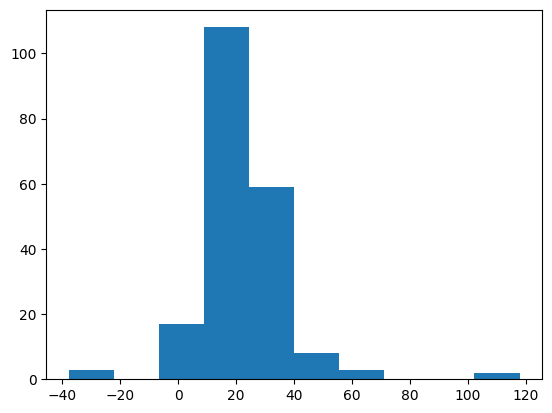

In [43]:
plt.hist(fit_t0)

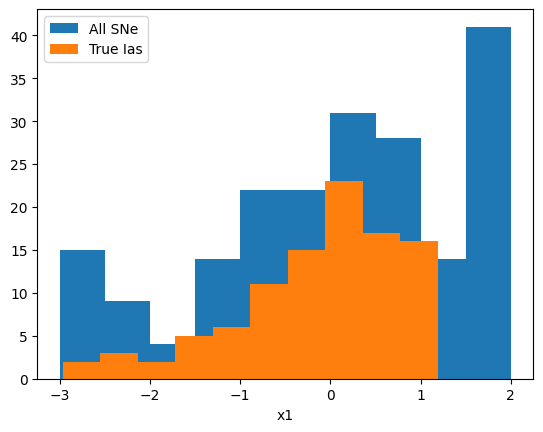

In [44]:
plt.hist(fit_x1, label="All SNe")
plt.hist([sn.true_params['x1'] for sn in true_ia_sne], label="True Ias")
plt.xlabel("x1")
plt.legend()

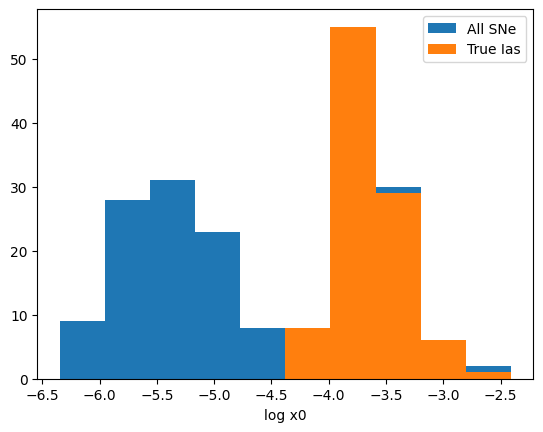

In [45]:
_, bins, _ = plt.hist(np.log10(fit_x0), label="All SNe")
plt.hist(np.log10([sn.true_params['x0'] for sn in true_ia_sne]), label="True Ias", bins=bins)
plt.xlabel("log x0")
plt.legend()

In [46]:
ibc_mask = [sn in true_ibc_sne for sn in all_sne]

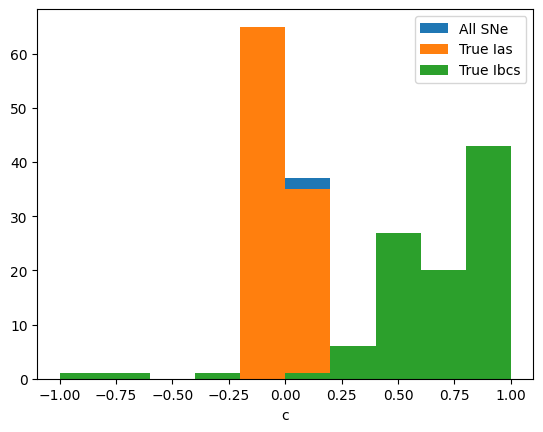

In [47]:
_, bins, _ = plt.hist(fit_c, label="All SNe")
plt.hist([sn.true_params['c'] for sn in true_ia_sne], label="True Ias", bins=bins)
plt.hist(fit_c[(len(fit_c)//2):len(fit_c)], label="True Ibcs", bins=bins)

plt.xlabel("c")
plt.legend()

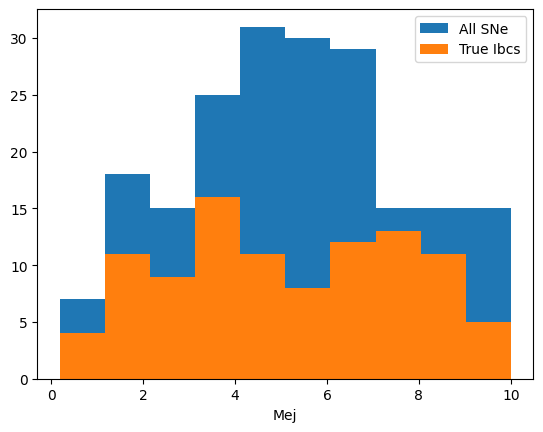

In [48]:
_, bins, _ = plt.hist(fit_mej, label="All SNe")
plt.hist([sn.true_params['mej'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

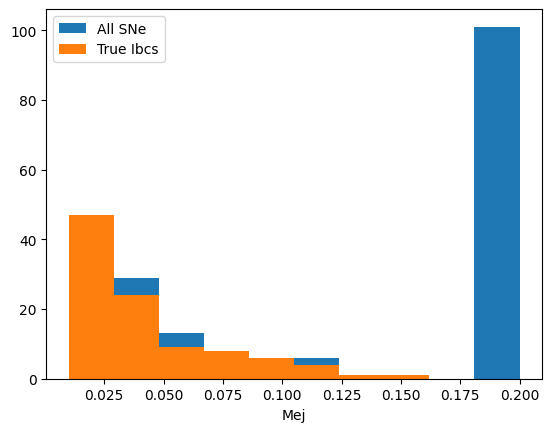

In [49]:
_, bins, _ = plt.hist(fit_fni, label="All SNe")
plt.hist([sn.true_params['fni'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

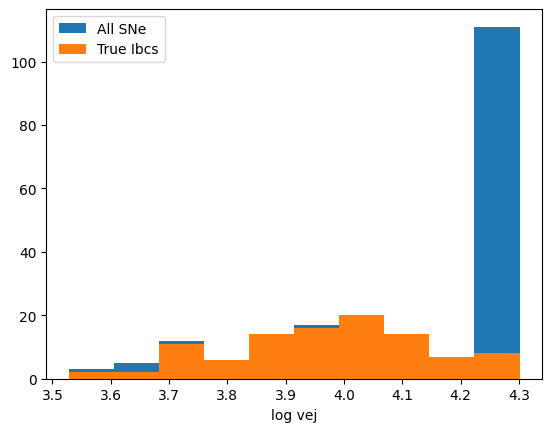

In [50]:
_, bins, _ = plt.hist(np.log10(fit_vej), label="All SNe")
plt.hist(np.log10([sn.true_params['vej'] for sn in true_ibc_sne]), label="True Ibcs", bins=bins)
plt.xlabel("log vej")
plt.legend()